# Predicting SAP stock prices
## Using PyTorch and SageMaker

---

Now that we have a basic understanding of how SageMaker works we will try to use it to construct a complete project from end to end. Our goal will be to have a simple web page which a user can use to enter a movie review. The web page will then send the review off to our deployed model which will predict the sentiment of the entered review.

## Instructions

> **Note**: Code and Markdown cells can be executed using the **Shift+Enter** keyboard shortcut. In addition, a cell can be edited by typically clicking it (double-click for Markdown cells) or by pressing **Enter** while it is highlighted.

## General Outline

Recall the general outline for SageMaker projects using a notebook instance.

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

For this project, you will be following the steps in the general outline with some modifications. 

First, you will not be testing the model in its own step. You will still be testing the model, however, you will do it by deploying your model and then using the deployed model by sending the test data to it. One of the reasons for doing this is so that you can make sure that your deployed model is working correctly before moving forward.

In addition, you will deploy and use your trained model a second time. In the second iteration you will customize the way that your trained model is deployed by including some of your own code. In addition, your newly deployed model will be used in the sentiment analysis web app.

## Step 1: Downloading the data

We use the historical data from a polish provide Stooq.
Visit https://stooq.com/q/d/?s=sap.de to fine-tune the data.

In [1]:
import numpy as np
import pandas as pd

# Global settings
use_volume = False
use_sinus_data = False

forecast_days = 1

In [2]:
%mkdir -p "data"
# Clean existing data if necessary
!rm -rf "data/*"

!curl -k -sS "https://stooq.com/q/d/l/?s=sap.de&i=d" > "data/data.raw.csv"
# i=d - interval daily (other: w,m,q,y - week, month, quarter, year)
# o=1100000 - options - binary mask 
# other...

We may want to start learning with simpler data, so here is the option to replace stock prices with `sin` signal

In [3]:
def create_target_for_supervised(src, target, shift=1):
    """
    This function shifts target forward by `shift` positions with respect to the src
    Example for shift=1:
    [a,b,c] [a,b,c] -> [a,b,c] [x,a,b]
    """
    src = pd.DataFrame(src)
    target = pd.DataFrame(target)
    
    src = src.iloc[:(shift * -1)]
    target = target.iloc[shift:]
    
    # Data was shifted and 'empty spaces' in form of NaNs emerged
    # We may fill it with zeros:
    # src.fillna(0, inplace=True)
    # or interpolate
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
    src.interpolate(method='nearest', inplace=True)
    target.interpolate(method='nearest', inplace=True)
    
    src.reset_index(inplace=True, drop=True)
    target.reset_index(inplace=True, drop=True)

    return src, target

def replace_stock_data_with_sine(input_data, target_data):
    np.random.seed(2)

    N = len(input_data)
    L = len(input_data)
    
    x = np.empty((N, L), 'int64')
    x[:] = np.array(range(L)).reshape(N, 1)
    data = np.sin(x / 3.1415 / 2.0).astype('float64')
    input_data['AvgPrice'] = data
    target_data['AvgPrice'] = data # target_data should be shifted with respect to input_data. We do it later
    input_data['Volume'] =  np.ones(N, 'float64')
    
    return input_data, target_data

## Step 2: Preparing and Processing the data

Default data range used at stooq is: September 1994 until today

In [4]:
import os
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt

def read_stock_data(data_dir='data/'):  
    ymd_date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    return pd.read_csv(data_dir+"data.raw.csv", parse_dates=['Date'], date_parser=ymd_date_parser)
   
    
def select_columns(raw):
    input_data = pd.DataFrame({
        "Volume": raw['Volume'],
        "AvgPrice": raw['Low'] + (raw['High'] - raw['Low'])/2
    })
    
    # Selecing columns for target
    # Low and High are added as a reference to manually check corectenss of data transformation
    target_data = pd.DataFrame({
        "AvgPrice": raw['Low'] + (raw['High'] - raw['Low'])/2
    })
    # Redorer columns
    input_data = input_data.reindex(columns=['AvgPrice', 'Volume'])
    target_data = target_data.reindex(columns=['AvgPrice'])

    return input_data, target_data


def plot_data(input_data, target_data, title= "no title", firt_days=60):
    plt.figure(figsize=(16,5))
    x_axis = range(0,len(target_data))
    plt.title(title)
    plt.plot(x_axis[:firt_days], input_data[:firt_days], 'b.-', label='input')
    plt.plot(x_axis[:firt_days], target_data[:firt_days], 'r.-', label='target')

    plt.legend(loc='best')
    plt.show()

In [5]:
raw_data = read_stock_data()
print("Raw data imported from the source:\n ", raw_data.head(5))


Raw data imported from the source:
          Date    Open    High     Low   Close    Volume
0 1994-09-13  2.9978  3.0020  2.9978  3.0020  161888.0
1 1994-09-14  2.9910  3.0377  2.9821  3.0377  420909.0
2 1994-09-16  3.0576  3.0576  3.0576  3.0576   97134.0
3 1994-09-20  3.0576  3.0576  3.0576  3.0576   48566.0
4 1994-09-21  3.0576  3.0576  3.0576  3.0576  161888.0


In [6]:
input_data, target_data = select_columns(raw_data)

if use_sinus_data:
    input_data, target_data = replace_stock_data_with_sine(input_data, target_data)

input_data, target_data = create_target_for_supervised(input_data, target_data, forecast_days)

print("Shape of input:\n", input_data.shape)
print("Shape of target:\n", target_data.shape)

print("Head of input:\n", input_data.head(5))
print("Head of target:\n", target_data.head(5))

Shape of input:
 (6046, 2)
Shape of target:
 (6046, 1)
Head of input:
    AvgPrice    Volume
0    2.9999  161888.0
1    3.0099  420909.0
2    3.0576   97134.0
3    3.0576   48566.0
4    3.0576  161888.0
Head of target:
    AvgPrice
0    3.0099
1    3.0576
2    3.0576
3    3.0576
4    3.0933


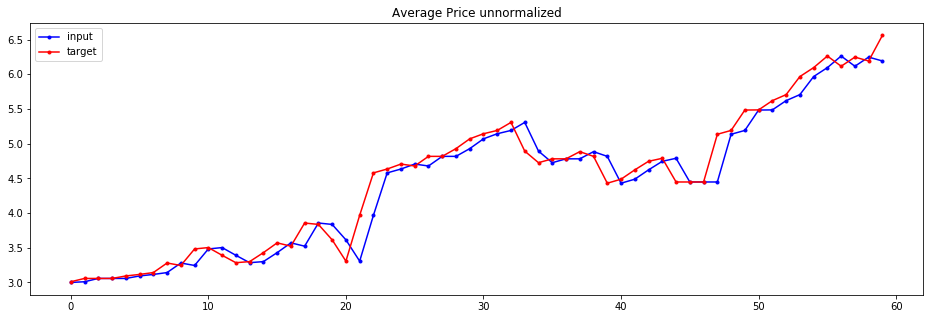

In [7]:
plot_data(input_data['AvgPrice'], target_data['AvgPrice'], "Average Price unnormalized", 60)

In [8]:
# Check if data is clean
# Check for NaN, None, and other non-numerical data
print("There are {} null values in input".format(input_data.isnull().values.sum()))
print("There are {} null values in target".format(target_data.isnull().values.sum()))

columns = input_data.columns.values.tolist()
for column in columns:
    index = input_data[column].index[input_data[column].apply(np.isnan)]
    print('Index {} in column {} is NaN or Null'.format(index,column))

There are 0 null values in input
There are 0 null values in target
Index Int64Index([], dtype='int64') in column AvgPrice is NaN or Null
Index Int64Index([], dtype='int64') in column Volume is NaN or Null


In [9]:
def divide_stock_data(data, labels):
    """Prepare training and test sets from stock data."""
    
    data_len = len(data)
    # division point between train and test data
    ratio = 0.98
    division_index = int(data_len*ratio)
    
    data_train = data[:division_index]
    data_test = data[division_index:]
    labels_train = labels[:division_index]
    labels_test = labels[division_index:]
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [10]:
train_X_orig, test_X_orig, train_y_orig, test_y_orig = divide_stock_data(input_data, target_data)
print("Stock days in data set: train = {}, test = {}".format(len(train_X_orig), len(test_X_orig)))

Stock days in data set: train = 5925, test = 121


## Scaling Data

Data should be normalized to simplify the learning process.
In this case, we use `StandardScaler` to standardize features by removing the mean and scaling to unit variance.

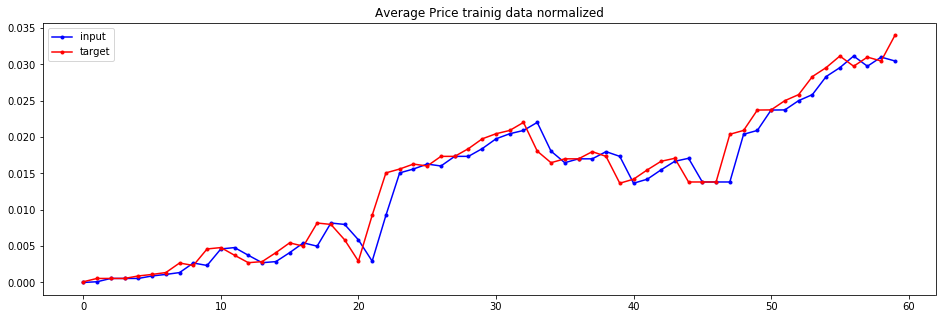

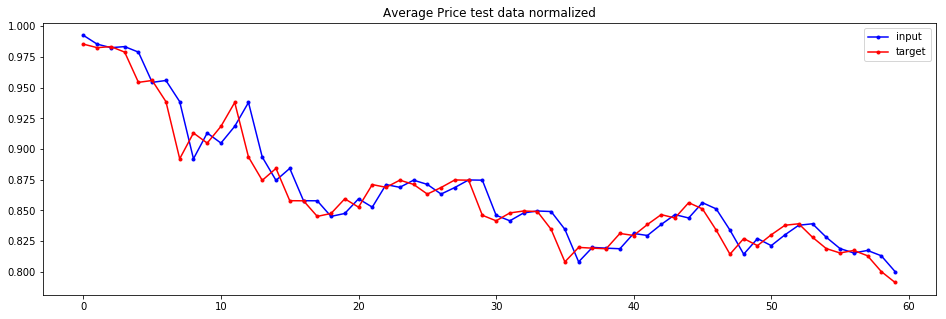

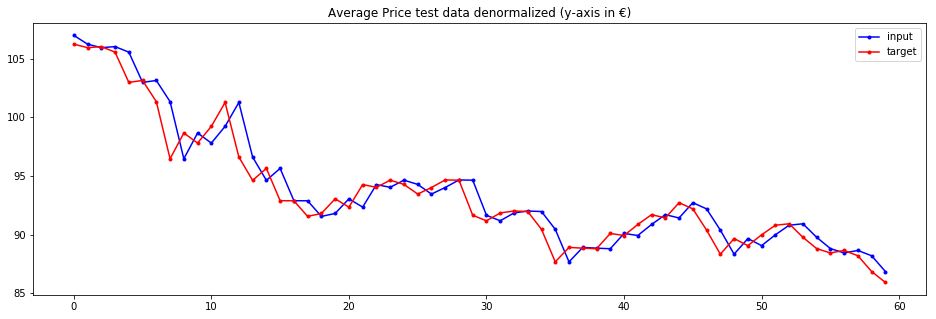

In [11]:
# Normalization of data
from pandas import Series
from sklearn.preprocessing import StandardScaler,MinMaxScaler

train_X = train_X_orig.copy()
train_y = train_y_orig.copy()
test_X  = test_X_orig.copy() 
test_y  = test_y_orig.copy() 

# We fit scalers using training data and then apply scaling to both training and test datasets
# We treat test data as we would never have seen it before

# scaler_volume = StandardScaler()
scaler_volume = MinMaxScaler()
scaler_volume.fit(train_X[['Volume']].values)

# scaler_price = StandardScaler()
scaler_price = MinMaxScaler()
scaler_price.fit(train_X[['AvgPrice']].values)


train_X[['Volume']] = scaler_volume.transform(train_X[['Volume']])
train_X[['AvgPrice']] = scaler_price.transform(train_X[['AvgPrice']])
train_y[['AvgPrice']] = scaler_price.transform(train_y[['AvgPrice']])

# test data is also normalized but using maximum from the training data
test_X[['Volume']] = scaler_volume.transform(test_X[['Volume']])

test_X[['AvgPrice']] = scaler_price.transform(test_X[['AvgPrice']])
test_y[['AvgPrice']] = scaler_price.transform(test_y[['AvgPrice']])

plot_data(train_X['AvgPrice'], train_y['AvgPrice'], "Average Price trainig data normalized", 60)
plot_data(test_X['AvgPrice'], test_y['AvgPrice'], "Average Price test data normalized", 60)

# How to go back to the unscaled price/volume
denorm_X=scaler_price.inverse_transform(test_X[['AvgPrice']])
denorm_y=scaler_price.inverse_transform(test_y[['AvgPrice']])

plot_data(denorm_X, denorm_y, "Average Price test data denormalized (y-axis in €)", 60)

Now that we have our training and testing sets unified and prepared, we should do a quick check and see an example of the data our model will be trained on. This is generally a good idea as it allows you to see how each of the further processing steps affects the reviews and it also ensures that the data has been loaded correctly.

In [12]:
print("Ideal prediction done at day 0:")
print(train_y[0:1])
print("Shoudl equal the average price from day 1:")
print(train_X[1:2])

print("\nThe same should hold for test data.")
print("Ideal prediction done at day 0:")
print(test_y[0:1])
print("Shoudl equal the average price from day 1:")
print(test_X[1:2])

Ideal prediction done at day 0:
   AvgPrice
0  0.000095
Shoudl equal the average price from day 1:
   AvgPrice    Volume
1  0.000095  0.008185

The same should hold for test data.
Ideal prediction done at day 0:
      AvgPrice
5925  0.985397
Shoudl equal the average price from day 1:
      AvgPrice    Volume
5926  0.985397  0.029966


## Step X: Upload the data to S3

Training and test data are packed into a csv file an uploaded to S3 from where Sagemaker jobs can pull the data.

In [13]:
data_dir = 'data'

pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join('data', 'train.csv'), header=False, index=False)


pd.concat([pd.DataFrame(test_y), pd.DataFrame(test_X)], axis=1) \
        .to_csv(os.path.join('data', 'test.csv'), header=False, index=False)

### Uploading the training data


Next, we need to upload the training data to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [14]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/stock-predictor-dojo1'

role = sagemaker.get_execution_role()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-628201230330


In [15]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

## Step 4: Build and Train the PyTorch Model

In the XGBoost notebook we discussed what a model is in the SageMaker framework. In particular, a model comprises three objects

 - Model Artifacts,
 - Training Code, and
 - Inference Code,
 
each of which interact with one another. In the XGBoost example we used training and inference code that was provided by Amazon. Here we will still be using containers provided by Amazon with the added benefit of being able to include our own custom code.

We will start by implementing our own neural network in PyTorch along with a training script. For the purposes of this project we have provided the necessary model object in the `model.py` file, inside of the `train` folder. You can see the provided implementation by running the cell below.

In [16]:
!pygmentize train/modelLstm.py

import torch
import torch.nn as nn
from torch.autograd import Variable

class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, dropout=0.25)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)),
                Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
       

The important takeaway from the implementation provided is that there are three parameters that we may wish to tweak to improve the performance of our model. These are the embedding dimension, the hidden dimension and the size of the vocabulary. We will likely want to make these parameters configurable in the training script so that if we wish to modify them we do not need to modify the script itself. We will see how to do this later on. To start we will write some of the training code in the notebook so that we can more easily diagnose any issues that arise.

First we will load a small portion of the training data set to use as a sample. It would be very time consuming to try and train the model completely in the notebook as we do not have access to a gpu and the compute instance that we are using is not particularly powerful. However, we can work on a small bit of the data to get a feel for how our training script is behaving.

In [37]:
import torch
import torch.utils.data

batch_size = 2

dummy_read = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None)

num_rows_train = (len(dummy_read) // batch_size) * batch_size

train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=num_rows_train)

# Order of data in train.csv:
# Y-Average  |  Y-Average  X-Volume
# to_predict |  INPUT VALUES...

# Turn the input pandas dataframe into tensors
# For Y, we select 3rd column - average price next day
# For X, we select all but first 3 columns - all data for the current day
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()

train_sample_X = None

if use_volume:
  train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).float()
else:
  train_sample_X = torch.from_numpy(train_sample.drop([0,2], axis=1).values).float()

#print(train_sample)
print(train_sample_y.shape)
print(train_sample_X.shape)

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=batch_size)

torch.Size([5924])
torch.Size([5924, 1])


### Writing the training method and testing it locally

Next we need to write the training code itself. This should be very similar to training methods that you have written before to train PyTorch models. We will leave any difficult aspects such as model saving / loading and parameter loading until a little later.

In [38]:
import torch
from torch import nn
from torch.autograd import Variable

   
def train(model, train_loader, epochs, optimizer, criterion, device):
    
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        
        
        for batch in train_loader:
            batch_X, batch_y = batch            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # convert data into Tensors
            # x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
            # y_tensor = torch.Tensor(y)
            x_tensor = torch.Tensor(batch_X).unsqueeze(0)
            model.zero_grad()
            
            output = model(x_tensor)
           
            loss = criterion(output.squeeze(), batch_y.float())
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            
            total_loss += loss.data.item()
        print("Epoch: {}, MSELoss: {}".format(epoch, total_loss / len(train_loader)))
    return model

import torch.optim as optim
from train.modelLstm import LSTM

input_size = 2 if use_volume else 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(input_dim=input_size, hidden_dim=64, batch_size=batch_size, output_dim=1, num_layers=2).to(device)

print(model)


optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

train(model, train_sample_dl, 30, optimizer, loss_fn, device)

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, dropout=0.25)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
Epoch: 1, MSELoss: 0.0005937854219794955
Epoch: 2, MSELoss: 0.002580478184629358
Epoch: 3, MSELoss: 0.0022053999091453864
Epoch: 4, MSELoss: 0.0014885032985292534
Epoch: 5, MSELoss: 0.001082900076354326
Epoch: 6, MSELoss: 0.0009758352989457395
Epoch: 7, MSELoss: 0.0011612714619671613
Epoch: 8, MSELoss: 0.0009099209157428588
Epoch: 9, MSELoss: 0.0007907472500969703
Epoch: 10, MSELoss: 0.0007025736327007775
Epoch: 11, MSELoss: 0.000609654576698342
Epoch: 12, MSELoss: 0.0005205033166199321
Epoch: 13, MSELoss: 0.0004768252318846294
Epoch: 14, MSELoss: 0.00043274174858669133
Epoch: 15, MSELoss: 0.0004226537745511351
Epoch: 16, MSELoss: 0.00040267261030311433
Epoch: 17, MSELoss: 0.0004008349680068749
Epoch: 18, MSELoss: 0.00041135121924801743
Epoch: 19, MSELoss: 0.00039117577369460974
Epoch: 20, MSELoss: 0.00040071794089176406
Epoch: 21, MSELoss: 0.0003963907793011851
Epoch

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, dropout=0.25)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

Supposing we have the training method above, we will test that it is working by writing a bit of code in the notebook that executes our training method on the small sample training set that we loaded earlier. The reason for doing this in the notebook is so that we have an opportunity to fix any errors that arise early when they are easier to diagnose.

In [45]:
import torch
import torch.utils.data

num_rows_test = (len(test_y) // batch_size) * batch_size

test_sample = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None, names=None, nrows=num_rows_test)
test_y = torch.from_numpy(test_sample[[0]].values).float().squeeze()

test_X = None
if use_volume:
  test_X = torch.from_numpy(test_sample.drop([0], axis=1).values).float()
else:
  test_X = torch.from_numpy(test_sample.drop([0,2], axis=1).values).float()



#print(train_sample)
print(test_y.shape)
print(test_X.shape)

# Build the dataset
test_ds = torch.utils.data.TensorDataset(test_X, test_y)
# Build the dataloader
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)


def test(model, test_loader, criterion, device):
    model.eval()
    data = dict()
    data['prediction'] = []
    data['expected'] = []
    data['loss'] = []
    total_loss = 0
    batch_no = 0

    for batch in test_loader:
        batch_X, batch_y = batch            
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # convert data into Tensors
        # x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        # y_tensor = torch.Tensor(y)
        x_tensor = torch.Tensor(batch_X).unsqueeze(0)

        output = model(x_tensor)
        loss = criterion(output.squeeze(), batch_y.float())
        
        # Convert from Tensor to NumPy Array
        data['prediction'].append(output.detach().numpy())
        data['expected'].append(batch_y.detach().numpy())
        data['loss'].append(loss.detach().numpy())
        total_loss += loss.data.item()
        batch_no += 1
    print("MSELoss total: {}".format(total_loss / len(test_loader)))
    return data

loss_fn = torch.nn.MSELoss()
result = test(model, test_dl, loss_fn, device)

# Remove batching
no_batch_result = dict()
for batch_no in range(0, len(result['prediction'])):
    
    pred = result['prediction'][batch_no]
    no_batch_result['prediction'].append(pred)
    no_batch_result['expected'].append(result['expected'][batch_no])
    
plot_data(no_batch_result['expected'], no_batch_result['prediction'], "Prediction/expectation in €)", 60)


torch.Size([120])
torch.Size([120, 1])
MSELoss total: 0.010388280066338969


KeyError: 'prediction'

# What is the problem?
- prediction is late 2 days
- model is asked to proedict data that it have neve seen before (test data conteins the highest prices in the history)

In [ ]:
break


In order to construct a PyTorch model using SageMaker we must provide SageMaker with a training script. We may optionally include a directory which will be copied to the container and from which our training code will be run. When the training container is executed it will check the uploaded directory (if there is one) for a `requirements.txt` file and install any required Python libraries, after which the training script will be run.

### (TODO) Training the model

When a PyTorch model is constructed in SageMaker, an entry point must be specified. This is the Python file which will be executed when the model is trained. Inside of the `train` directory is a file called `train.py` which has been provided and which contains most of the necessary code to train our model. The only thing that is missing is the implementation of the `train()` method which you wrote earlier in this notebook.

**TODO**: Copy the `train()` method written above and paste it into the `train/train.py` file where required.

The way that SageMaker passes hyperparameters to the training script is by way of arguments. These arguments can then be parsed and used in the training script. To see how this is done take a look at the provided `train/train.py` file.

In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 10,
                        'hidden_dim': 200,
                    })

In [ ]:
estimator.fit({'training': input_data})

## Step 5: Testing the model

As mentioned at the top of this notebook, we will be testing this model by first deploying it and then sending the testing data to the deployed endpoint. We will do this so that we can make sure that the deployed model is working correctly.

## Step 6: Deploy the model for testing

Now that we have trained our model, we would like to test it to see how it performs. Currently our model takes input of the form `review_length, review[500]` where `review[500]` is a sequence of `500` integers which describe the words present in the review, encoded using `word_dict`. Fortunately for us, SageMaker provides built-in inference code for models with simple inputs such as this.

There is one thing that we need to provide, however, and that is a function which loads the saved model. This function must be called `model_fn()` and takes as its only parameter a path to the directory where the model artifacts are stored. This function must also be present in the python file which we specified as the entry point. In our case the model loading function has been provided and so no changes need to be made.

**NOTE**: When the built-in inference code is run it must import the `model_fn()` method from the `train.py` file. This is why the training code is wrapped in a main guard ( ie, `if __name__ == '__main__':` )

Since we don't need to change anything in the code that was uploaded during training, we can simply deploy the current model as-is.

**NOTE:** When deploying a model you are asking SageMaker to launch an compute instance that will wait for data to be sent to it. As a result, this compute instance will continue to run until *you* shut it down. This is important to know since the cost of a deployed endpoint depends on how long it has been running for.

In other words **If you are no longer using a deployed endpoint, shut it down!**

**TODO:** Deploy the trained model.

In [18]:
# TODO: Deploy the trained model
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

NameError: name 'estimator' is not defined

## Step 7 - Use the model for testing

Once deployed, we can read in the test data and send it off to our deployed model to get some results. Once we collect all of the results we can determine how accurate our model is.

In [19]:
test_X = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

NameError: name 'test_X_len' is not defined

In [20]:
# We split the data into chunks and send each chunk seperately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [21]:
predictions = predict(test_X.values)
predictions = [round(num) for num in predictions]

NameError: name 'predictor' is not defined

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

NameError: name 'predictions' is not defined

**Question:** How does this model compare to the XGBoost model you created earlier? Why might these two models perform differently on this dataset? Which do *you* think is better for sentiment analysis?

**Answer:**

### (TODO) More testing

We now have a trained model which has been deployed and which we can send processed reviews to and which returns the predicted sentiment. However, ultimately we would like to be able to send our model an unprocessed review. That is, we would like to send the review itself as a string. For example, suppose we wish to send the following review to our model.

In [23]:
test_review = 'The simplest pleasures in life are the best, and this film is one of them. Combining a rather basic storyline of love and adventure this movie transcends the usual weekend fair with wit and unmitigated charm.'

The question we now need to answer is, how do we send this review to our model?

Recall in the first section of this notebook we did a bunch of data processing to the IMDb dataset. In particular, we did two specific things to the provided reviews.
 - Removed any html tags and stemmed the input
 - Encoded the review as a sequence of integers using `word_dict`
 
In order process the review we will need to repeat these two steps.

**TODO**: Using the `review_to_words` and `convert_and_pad` methods from section one, convert `test_review` into a numpy array `test_data` suitable to send to our model. Remember that our model expects input of the form `review_length, review[500]`.

In [24]:
# TODO: Convert test_review into a form usable by the model and save the results in test_data
test_data = None

words = review_to_words(test_review)
converted, length = convert_and_pad(word_dict, words)
print("Review length: {}".format(length))
test_data = np.array([length] + converted)
# print(test_data)
# Need to reshape this further
test_data = np.reshape(test_data, (-1, 501))
print(test_data)

NameError: name 'review_to_words' is not defined

Now that we have processed the review, we can send the resulting array to our model to predict the sentiment of the review.

In [25]:
predictor.predict(test_data)

NameError: name 'predictor' is not defined

Since the return value of our model is close to `1`, we can be certain that the review we submitted is positive.

### Delete the endpoint

Of course, just like in the XGBoost notebook, once we've deployed an endpoint it continues to run until we tell it to shut down. Since we are done using our endpoint for now, we can delete it.

In [26]:
estimator.delete_endpoint()

NameError: name 'estimator' is not defined

## Step 6 (again) - Deploy the model for the web app

Now that we know that our model is working, it's time to create some custom inference code so that we can send the model a review which has not been processed and have it determine the sentiment of the review.

As we saw above, by default the estimator which we created, when deployed, will use the entry script and directory which we provided when creating the model. However, since we now wish to accept a string as input and our model expects a processed review, we need to write some custom inference code.

We will store the code that we write in the `serve` directory. Provided in this directory is the `model.py` file that we used to construct our model, a `utils.py` file which contains the `review_to_words` and `convert_and_pad` pre-processing functions which we used during the initial data processing, and `predict.py`, the file which will contain our custom inference code. Note also that `requirements.txt` is present which will tell SageMaker what Python libraries are required by our custom inference code.

When deploying a PyTorch model in SageMaker, you are expected to provide four functions which the SageMaker inference container will use.
 - `model_fn`: This function is the same function that we used in the training script and it tells SageMaker how to load our model.
 - `input_fn`: This function receives the raw serialized input that has been sent to the model's endpoint and its job is to de-serialize and make the input available for the inference code.
 - `output_fn`: This function takes the output of the inference code and its job is to serialize this output and return it to the caller of the model's endpoint.
 - `predict_fn`: The heart of the inference script, this is where the actual prediction is done and is the function which you will need to complete.

For the simple website that we are constructing during this project, the `input_fn` and `output_fn` methods are relatively straightforward. We only require being able to accept a string as input and we expect to return a single value as output. You might imagine though that in a more complex application the input or output may be image data or some other binary data which would require some effort to serialize.

### (TODO) Writing inference code

Before writing our custom inference code, we will begin by taking a look at the code which has been provided.

In [27]:
!pygmentize serve/predict.py

import argparse
import json
import os
import pickle
import sys
import sagemaker_containers
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from model import LSTMClassifier

from utils import review_to_words, convert_and_pad

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier(model_info['embedding_dim'], model_info['hidden_dim'], model_info['vocab_size'])

    # Load the store model parameters.
    model_path = os.path.join(mod

As mentioned earlier, the `model_fn` method is the same as the one provided in the training code and the `input_fn` and `output_fn` methods are very simple and your task will be to complete the `predict_fn` method. Make sure that you save the completed file as `predict.py` in the `serve` directory.

**TODO**: Complete the `predict_fn()` method in the `serve/predict.py` file.

### Deploying the model

Now that the custom inference code has been written, we will create and deploy our model. To begin with, we need to construct a new PyTorchModel object which points to the model artifacts created during training and also points to the inference code that we wish to use. Then we can call the deploy method to launch the deployment container.

**NOTE**: The default behaviour for a deployed PyTorch model is to assume that any input passed to the predictor is a `numpy` array. In our case we want to send a string so we need to construct a simple wrapper around the `RealTimePredictor` class to accomodate simple strings. In a more complicated situation you may want to provide a serialization object, for example if you wanted to sent image data.

In [28]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     source_dir='serve',
                     predictor_cls=StringPredictor)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

NameError: name 'estimator' is not defined

### Testing the model

Now that we have deployed our model with the custom inference code, we should test to see if everything is working. Here we test our model by loading the first `250` positive and negative reviews and send them to the endpoint, then collect the results. The reason for only sending some of the data is that the amount of time it takes for our model to process the input and then perform inference is quite long and so testing the entire data set would be prohibitive.

In [ ]:
import glob

def test_reviews(data_dir='../data/aclImdb', stop=250):
    
    results = []
    ground = []
    
    # We make sure to test both positive and negative reviews    
    for sentiment in ['pos', 'neg']:
        
        path = os.path.join(data_dir, 'test', sentiment, '*.txt')
        files = glob.glob(path)
        
        files_read = 0
        
        print('Starting ', sentiment, ' files')
        
        # Iterate through the files and send them to the predictor
        for f in files:
            with open(f) as review:
                # First, we store the ground truth (was the review positive or negative)
                if sentiment == 'pos':
                    ground.append(1)
                else:
                    ground.append(0)
                # Read in the review and convert to 'utf-8' for transmission via HTTP
                review_input = review.read().encode('utf-8')
                # Send the review to the predictor and store the results
                results.append(int(predictor.predict(review_input)))
                
            # Sending reviews to our endpoint one at a time takes a while so we
            # only send a small number of reviews
            files_read += 1
            if files_read == stop:
                break
            
    return ground, results

In [ ]:
ground, results = test_reviews()

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(ground, results)

NameError: name 'ground' is not defined

As an additional test, we can try sending the `test_review` that we looked at earlier.

In [30]:
predictor.predict(test_review)

NameError: name 'predictor' is not defined

Now that we know our endpoint is working as expected, we can set up the web page that will interact with it. If you don't have time to finish the project now, make sure to skip down to the end of this notebook and shut down your endpoint. You can deploy it again when you come back.

## Step 7 (again): Use the model for the web app

> **TODO:** This entire section and the next contain tasks for you to complete, mostly using the AWS console.

So far we have been accessing our model endpoint by constructing a predictor object which uses the endpoint and then just using the predictor object to perform inference. What if we wanted to create a web app which accessed our model? The way things are set up currently makes that not possible since in order to access a SageMaker endpoint the app would first have to authenticate with AWS using an IAM role which included access to SageMaker endpoints. However, there is an easier way! We just need to use some additional AWS services.

<img src="Web App Diagram.svg">

The diagram above gives an overview of how the various services will work together. On the far right is the model which we trained above and which is deployed using SageMaker. On the far left is our web app that collects a user's movie review, sends it off and expects a positive or negative sentiment in return.

In the middle is where some of the magic happens. We will construct a Lambda function, which you can think of as a straightforward Python function that can be executed whenever a specified event occurs. We will give this function permission to send and recieve data from a SageMaker endpoint.

Lastly, the method we will use to execute the Lambda function is a new endpoint that we will create using API Gateway. This endpoint will be a url that listens for data to be sent to it. Once it gets some data it will pass that data on to the Lambda function and then return whatever the Lambda function returns. Essentially it will act as an interface that lets our web app communicate with the Lambda function.

### Setting up a Lambda function

The first thing we are going to do is set up a Lambda function. This Lambda function will be executed whenever our public API has data sent to it. When it is executed it will receive the data, perform any sort of processing that is required, send the data (the review) to the SageMaker endpoint we've created and then return the result.

#### Part A: Create an IAM Role for the Lambda function

Since we want the Lambda function to call a SageMaker endpoint, we need to make sure that it has permission to do so. To do this, we will construct a role that we can later give the Lambda function.

Using the AWS Console, navigate to the **IAM** page and click on **Roles**. Then, click on **Create role**. Make sure that the **AWS service** is the type of trusted entity selected and choose **Lambda** as the service that will use this role, then click **Next: Permissions**.

In the search box type `sagemaker` and select the check box next to the **AmazonSageMakerFullAccess** policy. Then, click on **Next: Review**.

Lastly, give this role a name. Make sure you use a name that you will remember later on, for example `LambdaSageMakerRole`. Then, click on **Create role**.

#### Part B: Create a Lambda function

Now it is time to actually create the Lambda function.

Using the AWS Console, navigate to the AWS Lambda page and click on **Create a function**. When you get to the next page, make sure that **Author from scratch** is selected. Now, name your Lambda function, using a name that you will remember later on, for example `sentiment_analysis_func`. Make sure that the **Python 3.6** runtime is selected and then choose the role that you created in the previous part. Then, click on **Create Function**.

On the next page you will see some information about the Lambda function you've just created. If you scroll down you should see an editor in which you can write the code that will be executed when your Lambda function is triggered. In our example, we will use the code below. 

```python
# We need to use the low-level library to interact with SageMaker since the SageMaker API
# is not available natively through Lambda.
import boto3

def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = '**ENDPOINT NAME HERE**',    # The name of the endpoint we created
                                       ContentType = 'text/plain',                 # The data format that is expected
                                       Body = event['body'])                       # The actual review

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }
```

Once you have copy and pasted the code above into the Lambda code editor, replace the `**ENDPOINT NAME HERE**` portion with the name of the endpoint that we deployed earlier. You can determine the name of the endpoint using the code cell below.

In [31]:
predictor.endpoint

NameError: name 'predictor' is not defined

Once you have added the endpoint name to the Lambda function, click on **Save**. Your Lambda function is now up and running. Next we need to create a way for our web app to execute the Lambda function.

### Setting up API Gateway

Now that our Lambda function is set up, it is time to create a new API using API Gateway that will trigger the Lambda function we have just created.

Using AWS Console, navigate to **Amazon API Gateway** and then click on **Get started**.

On the next page, make sure that **New API** is selected and give the new api a name, for example, `sentiment_analysis_api`. Then, click on **Create API**.

Now we have created an API, however it doesn't currently do anything. What we want it to do is to trigger the Lambda function that we created earlier.

Select the **Actions** dropdown menu and click **Create Method**. A new blank method will be created, select its dropdown menu and select **POST**, then click on the check mark beside it.

For the integration point, make sure that **Lambda Function** is selected and click on the **Use Lambda Proxy integration**. This option makes sure that the data that is sent to the API is then sent directly to the Lambda function with no processing. It also means that the return value must be a proper response object as it will also not be processed by API Gateway.

Type the name of the Lambda function you created earlier into the **Lambda Function** text entry box and then click on **Save**. Click on **OK** in the pop-up box that then appears, giving permission to API Gateway to invoke the Lambda function you created.

The last step in creating the API Gateway is to select the **Actions** dropdown and click on **Deploy API**. You will need to create a new Deployment stage and name it anything you like, for example `prod`.

You have now successfully set up a public API to access your SageMaker model. Make sure to copy or write down the URL provided to invoke your newly created public API as this will be needed in the next step. This URL can be found at the top of the page, highlighted in blue next to the text **Invoke URL**.

## Step 4: Deploying our web app

Now that we have a publicly available API, we can start using it in a web app. For our purposes, we have provided a simple static html file which can make use of the public api you created earlier.

In the `website` folder there should be a file called `index.html`. Download the file to your computer and open that file up in a text editor of your choice. There should be a line which contains **\*\*REPLACE WITH PUBLIC API URL\*\***. Replace this string with the url that you wrote down in the last step and then save the file.

Now, if you open `index.html` on your local computer, your browser will behave as a local web server and you can use the provided site to interact with your SageMaker model.

If you'd like to go further, you can host this html file anywhere you'd like, for example using github or hosting a static site on Amazon's S3. Once you have done this you can share the link with anyone you'd like and have them play with it too!

> **Important Note** In order for the web app to communicate with the SageMaker endpoint, the endpoint has to actually be deployed and running. This means that you are paying for it. Make sure that the endpoint is running when you want to use the web app but that you shut it down when you don't need it, otherwise you will end up with a surprisingly large AWS bill.

**TODO:** Make sure that you include the edited `index.html` file in your project submission.

Now that your web app is working, trying playing around with it and see how well it works.

**Question**: Give an example of a review that you entered into your web app. What was the predicted sentiment of your example review?

**Answer:**

### Delete the endpoint

Remember to always shut down your endpoint if you are no longer using it. You are charged for the length of time that the endpoint is running so if you forget and leave it on you could end up with an unexpectedly large bill.

In [32]:
predictor.delete_endpoint()

NameError: name 'predictor' is not defined